In [6]:
from skimage.filters import sobel
from skimage import exposure
from numpy.ma import getdata
import numpy as np
from matplotlib import pyplot as plt

(max_int_arc)=
# Image processing
```{figure} ./images/max_arc/2ndmaxarc.png
:scale: 50%
:align: right
:name: fig:intensity_azimuth
Image intensity over azimuth, for a specific elevation row.
```
Looking at the images, we notice that two arcs seem to form, the outer one being less distinct. We will refer to that as the second maxima arc, as this second peak is observed consistently when tracing the intensity evolution over the azimuth angles for each row as seen in {ref}`fig:intensity_azimuth`. This shall not be confused with the second emissivity maximum described in the previous section, where we were referring to the 3D structures of the emissivity.

If we attempt to trace the maximum pixel per row-elevation angle, we will notice prominent jumps from the maximum intensity arc to the second maximum, especially towards the edges where the intensity of the inner arc drops relative to the outer one. Attempts to discard the jumps directly proved unsuccessful since the limit in the azimuth step between rows simply slowly moved the curve to the outer arc.

Several approaches were taken in attempting to mitigate this. The failed attempts will not be showcased here (mainly because I deleted the code) but a descreption of them can be found in the MasterThesisPB.pdf.

We can first load the images by initializing the `Image` object. From this we can get the images, the image coordinates (elevation, azimuth) and the positions and orientation of the satellite. For the maximum intensity arc extraction we will need only the images.

In [ ]:
from TangentFitting import Images
images = Images()

There are several image processing tools and libraries that can aide us in smoothing the image or increasing the contrast to reduce the noise and make some features more distinct. Here we increase the contrast of the images using the [skimage](https://scikit-image.org/docs/stable/api/skimage.html) library and apply a 1 sigma Gaussian filter to smooth the noise. We then find the maximum azimuth index for each elevation and discard the ones that have a jump larger than 2 indexes. In the pictures approaching the magnetopause random arcs are being detected, so we discard the filtered array that are smaller than 20 points (the rest have been discarded due to jumps), as well as the ones that have an average intensity smaller than 0.2 normalized, since low intensities are expected inside the magnetopause. 

We can apply a similar procedure to derive diagnostics about the maximum gradient arc as well. We do this by passing the images through an edge detection filter - `skimage.filters.sobel` - which by definition extracts the maximum gradients in an image.

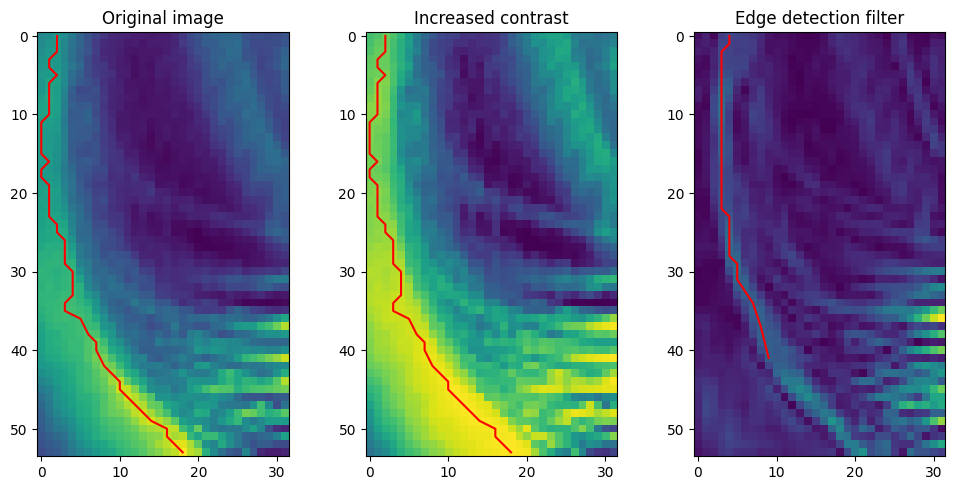

In [51]:
# Choose an image as an example
i = 77
# Original, increased contrast, edge detection filter
img = images.images[i]
img_contrast = exposure.equalize_hist(np.array(getdata(img)))
img_sobel = sobel(img)
captions = ['Original image', 'Increased contrast', 'Edge detection filter']

# Find maximum intensity arc, with limit on the maximum jump from row to row
fig, axs = plt.subplots(1, 3, figsize=(10,5))
count =0

for image in [img, img_contrast,img_sobel]:
    max_x = []
    y_vals = np.arange(image.shape[0])

    for y in y_vals:
        row = image[y, :]
        x = np.argmax(row)
        max_x.append(x)
    max_x_filtered = [max_x[0]]
    y_filtered = [y_vals[0]]

    # Limit jump between rows
    for i in range(1, len(max_x)):
        if abs(max_x[i] - max_x_filtered[-1]) <= 2:  # Set your tolerance here
            max_x_filtered.append(max_x[i])
            y_filtered.append(y_vals[i])

    # Limit minimum intensity of the curve (inside the magnetopause its low - discard this detection)
    threshold = 0.2  
    curve_intensity = np.mean(img[y_vals, max_x])
    if curve_intensity < 0.3:
        y_filtered = []
        max_x_filtered = []
    if len(y_filtered) < 20:
        y_filtered = []
        max_x_filtered = []

    # Plot
    axs[count].imshow(image, cmap='viridis')
    axs[count].plot(max_x_filtered, y_filtered, color='red', linewidth=1.5)
    axs[count].set_title(captions[count])
    count +=1

plt.tight_layout()
plt.show()